In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

windows_os = False

if windows_os:
    base_path = "C:/Users"
else:
    base_path = r"/media/gianlucanogara/Windows/Users"

### Load data

In [2]:
destination_path = base_path + r"/gianluca.nogara/Desktop/Repo/Vaccines_Discussion_Italy/Italian/files/tweets"

In [21]:
df = pd.read_csv(destination_path + "/tweets.csv", lineterminator='\n', low_memory=False, encoding="utf-8")
original = df[df["in_reply_to_screen_name"].isna() & df["rt_created_at"].isna() & df["quoted_status_id"].isna()]
reply = df[df["in_reply_to_user_id"].notna() & df["quoted_status_id"].isna()]
retweet = df[df["rt_created_at"].notna()]
quote = df[df["quoted_status_id"].notna() & df["rt_created_at"].isna()]
del df

In [3]:
tweets_with_urls = pd.read_parquet(destination_path+r'/tweets_w_urls_decompressed (1.0).parquet',
                               engine='fastparquet')

In [4]:
tweets_with_urls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030912 entries, 0 to 1030911
Data columns (total 49 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   id                         1030912 non-null  int64  
 1   id_str                     1030912 non-null  int64  
 2   created_at                 1030912 non-null  object 
 3   user_id                    1030912 non-null  int64  
 4   user_screen_name           1030912 non-null  object 
 5   user_verified              1030912 non-null  bool   
 6   user_created_at            1030912 non-null  object 
 7   text                       1030912 non-null  object 
 8   source                     1030912 non-null  object 
 9   coordinates                950 non-null      object 
 10  is_quote_status            1030912 non-null  bool   
 11  retweet_count              1030912 non-null  int64  
 12  favorite_count             1030912 non-null  int64  
 13  favorited   

In [5]:
value = []
for i in tqdm(tweets_with_urls["urls"]):
    url_exp = i.split(" ")
    lst_inside = []
    for exp in range(len(url_exp)):
        if url_exp[exp] == "'expanded_url':":
            lst_inside.append(url_exp[exp+1][1:-2])
    value.append(lst_inside)


  0%|          | 0/1030912 [00:00<?, ?it/s]

In [6]:
def extract_domain_list(url_list):
    domain_list = []
    cont = 0
    for url in url_list:
        cont = cont + 1
        inside = []
        for i in url:
            try:
                x = i.split("/")[2]
            except:
                x = "napolimagazine.com"
            if "www." in x:
                x = x[4:]
            inside.append(x)
        domain_list.append(inside)
    return domain_list

In [7]:
x = extract_domain_list(value)

In [8]:
print(len(x))
print(len(tweets_with_urls))
tweets_with_urls["domain"] = x

1030912
1030912


In [10]:
# tweets_with_urls.to_parquet(destination_path+"tweets_with_domains (2.0).parquet", index=False)

# Domain with the same name written in a different way

In [113]:
def normalize_domains(domain_list):
    for idx in range(len(domain_list)):
        domain=domain_list[idx]
        if domain in domain_normalize_df['initial_domain'].values:
            domain_list[idx] = domain_list[idx].replace(domain, domain_normalize_df[domain_normalize_df['initial_domain']==domain]['final_domain'].values[0])
    return domain_list

In [3]:
path_cred = base_path +  "/gianluca.nogara/Desktop/Repo/Vaccines_Discussion_Italy/Italian/files"

In [66]:
#read csv with "initial_domain" and "final_domain" to substitute name of same domain expressed in different ways
domain_normalize_df = pd.read_csv(path_cred+'Domain_to_normalize.csv', sep=',')
domain_normalize_df.drop_duplicates(inplace=True)
domain_normalize_df

In [130]:
#create df with one row for every domain
domain_df = tweets_with_urls['domain'].apply(pd.Series).reset_index().melt(id_vars='index').dropna()[['index', 'value']].set_index('index') #create df of url with one url per row

# Credibility

In [11]:
path_cred = base_path +  "/gianluca.nogara/Desktop/Repo/Vaccines_Discussion_Italy/Italian/files/domains"

In [12]:
#change path and filename 
wider_cred_sources_df = pd.read_csv(path_cred+r'/final_urls.csv')
high_cred_df = wider_cred_sources_df[wider_cred_sources_df['credibility'] == 'high']
high_cred_df.drop_duplicates(inplace=True)
low_cred_df = wider_cred_sources_df[wider_cred_sources_df['credibility'] == 'low']
low_cred_df.drop_duplicates(inplace=True)

In [13]:
high_cred_df

,url,credibility
40,noidiminerva.it,high
43,superquark.rai.it,high
45,leganerd.com,high
49,medicisenzafrontiere.it,high
50,avvenire.it,high
...,...,...
1553,umbriajournal.com,high
1554,sardiniapost.it,high
1555,emergency-live.com,high
1556,newsmondo.it,high


In [14]:
low_cred_df

,url,credibility
0,il-quotidiano.info,low
1,terrarealtime.blogspot.com,low
2,it.sputniknews.com,low
3,laverita.info,low
4,liberoquotidiano.it,low
...,...,...
1552,lecronachelucane.it,low
1557,tristemondo.it,low
1559,pointofnews.it,low
1560,m.dagospia.com,low


In [15]:
low_cred_df = low_cred_df.rename(columns={"url": "LOW"})
high_cred_df = high_cred_df.rename(columns={"url": "HIGH"})

In [11]:
social_media_df = pd.read_excel(path_cred+r'/social_media_sources.xlsx')
social_media_df.drop_duplicates(inplace=True)

In [12]:
social_media_df

,SOCIAL-MEDIA
0,twitter.com
1,instagram.com
2,youtu.be
3,youtube.com
4,facebook.com
6,lnkd.in
7,t.me
8,m.facebook.com
9,t.co
10,pscp.tv


In [13]:
print(f'Possible low credibility sources = {len(low_cred_df)}')
print(f'Possible high credibility sources = {len(high_cred_df)}')
print(f'Possible social media sources = {len(social_media_df)}')

Possible low credibility sources = 1244
Possible high credibility sources = 281
Possible social media sources = 12


In [24]:
tweets_with_urls = pd.read_parquet(destination_path + r'/tweets_with_domains (2.0).parquet', engine="pyarrow")
original_w_urls = tweets_with_urls[tweets_with_urls["in_reply_to_screen_name"].isna() & tweets_with_urls["rt_created_at"].isna() & tweets_with_urls["quoted_status_id"].isna()]
quote_w_urls = tweets_with_urls[tweets_with_urls["quoted_status_id"].notna() & tweets_with_urls["rt_created_at"].isna()]
reply_w_urls = tweets_with_urls[tweets_with_urls["in_reply_to_user_id"].notna() & tweets_with_urls["quoted_status_id"].isna()]
retweet_w_urls = tweets_with_urls[tweets_with_urls["rt_created_at"].notna()]
tweets_with_urls = pd.concat([original_w_urls, quote_w_urls], axis=0)
print(len(tweets_with_urls))

725840


In [23]:
print(len(original_w_urls) / len(original))
print(len(quote_w_urls) / len(quote))
print(len(retweet_w_urls) / len(retweet))
print(len(reply_w_urls) / len(reply))

0.6271581161558214
1.0
0.10719338528620466
0.07228316924519457


In [25]:
tweets_with_urls

,id,id_str,created_at,user_id,user_screen_name,user_verified,user_created_at,text,source,coordinates,...,hashtags,symbols,user_mentions,urls,polls,media,user_tweets_count,user_friends_count,user_followers_count,domain
0,1221737654909382662,1221737654909382662,Mon Jan 27 10:12:10 +0000 2020,589884969,LecceSette,False,Fri May 25 08:09:46 +0000 2012,"Minaccia morbillo nel Salento, Asl: ""Vaccinars...","<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",None,...,[],[],[],"[{'url': 'https://t.co/CY0qiQFk6s', 'expanded_...",[],[],NaN,NaN,NaN,[leccesette.it]
1,1221738978585563136,1221738978585563136,Mon Jan 27 10:17:25 +0000 2020,166708308,Asgard_Hydra,False,Wed Jul 14 20:31:11 +0000 2010,Ricercatori a lavoro per produrre vaccino cont...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",None,...,[],[],[],"[{'url': 'https://t.co/2bcyuvpnhj', 'expanded_...",[],[],NaN,NaN,NaN,[tech.everyeye.it]
3,1221735550585053186,1221735550585053186,Mon Jan 27 10:03:48 +0000 2020,1019640307065982979,CeSPI_Roma,False,Wed Jul 18 17:49:28 +0000 2018,Per chi crede nella democrazia nel rispetto de...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",None,...,"[{'text': 'antisemitismo', 'indices': [118, 13...",[],"[{'screen_name': 'pierofassino', 'name': 'Pier...","[{'url': 'https://t.co/bPHttOpFcg', 'expanded_...",[],"[{'id': 1221735545799352322, 'id_str': '122173...",NaN,NaN,NaN,[cespi.it]
7,1221736713355173891,1221736713355173891,Mon Jan 27 10:08:25 +0000 2020,605246031,OtticaSilverio,False,Mon Jun 11 06:15:33 +0000 2012,"""La memoria è l’unico vaccino contro\nl’indiff...","<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",None,...,"[{'text': '27gennaio', 'indices': [68, 78]}, {...",[],[],"[{'url': 'https://t.co/d94LjNROdb', 'expanded_...",[],"[{'id': 1221736712335962112, 'id_str': '122173...",NaN,NaN,NaN,[instagram.com]
8,1221739674022162432,1221739674022162432,Mon Jan 27 10:20:11 +0000 2020,823552947581812736,Aemmedi,False,Mon Jan 23 15:28:18 +0000 2017,"#Colesterolo, al via i test per il vaccino in ...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",None,...,"[{'text': 'Colesterolo', 'indices': [0, 12]}]",[],"[{'screen_name': 'ilmessaggeroit', 'name': 'Il...","[{'url': 'https://t.co/YINcjBn5MC', 'expanded_...",[],[],NaN,NaN,NaN,[ilmessaggero.it]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030893,1394609204304941062,1394609204304941062,Tue May 18 11:01:59 +0000 2021,1071673650,dimissia,False,Tue Jan 08 18:47:01 +0000 2013,Cosa accade quando ti vaccini: https://t.co/55...,"<a href=""http://twitter.com/download/android"" ...",None,...,[],[],[],"[{'url': 'https://t.co/55vgfQNnlE', 'expanded_...",[],"[{'id': 1394609195555639298, 'id_str': '139460...",101873.0,1667.0,1273.0,[twitter.com]
1030898,1394609761941921793,1394609761941921793,Tue May 18 11:04:12 +0000 2021,3031108244,InMonsterland,False,Thu Feb 19 18:36:18 +0000 2015,Capito la non logica di questi? https://t.co/Q...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",None,...,[],[],[],"[{'url': 'https://t.co/QDxocGtG98', 'expanded_...",[],[],54859.0,979.0,2858.0,[twitter.com]
1030902,1394609630542811138,1394609630542811138,Tue May 18 11:03:41 +0000 2021,1402708182,BansCollector,False,Sat May 04 16:15:39 +0000 2013,"@stebaraz Quando hai voglia e tempo, che ne pe...","<a href=""https://mobile.twitter.com"" rel=""nofo...",None,...,[],[],"[{'screen_name': 'stebaraz', 'name': 'Stefano ...","[{'url': 'https://t.co/2bHtlPR7dG', 'expanded_...",[],[],51214.0,1532.0,1087.0,[twitter.com]
1030905,1394609943685304323,1394609943685304323,Tue May 18 11:04:55 +0000 2021,2263295580,JamesB04016,False,Thu Dec 26 20:29:10 +0000 2013,Cazzo hanno usato le prime dosi per vaccinare ...,"<a href=""http://twitter.com/download/android"" ...",None,...,[],[],[],"[{'url': 'https://t.co/OspeMRyENg', 'expanded_...",[],[],20292.0,31.0,89.0,[twitter.com]


In [26]:
lst = []
lst_domains = []
for row in tqdm(tweets_with_urls.itertuples()):
    lst_inside = []
    for i in row.domain:
        lst_inside.append(i.lower())
    lst.append(len(row.domain))
    lst_domains.append(lst_inside)
tweets_with_urls["number_of_urls"] = lst
tweets_with_urls["domain"] = lst_domains

0it [00:00, ?it/s]

In [21]:
low = list(low_cred_df["LOW"])
high = list(high_cred_df["HIGH"])
social = list(social_media_df["SOCIAL-MEDIA"])
list_of_low = []
list_of_high = []
list_of_unkw = []
list_of_social = []
for row in tqdm(tweets_with_urls.itertuples()):
    value_low = 0
    value_high = 0
    value_unk= 0
    value_social = 0
    for domain in row.domain:
        if domain in low:
            value_low = value_low + 1 
        elif domain in high:
            value_high = value_high + 1
        elif domain in social:
            value_social = value_social + 1
        else:
            value_unk = value_unk+ 1
    list_of_low.append(value_low)
    list_of_high.append(value_high)
    list_of_unkw.append(value_unk)
    list_of_social.append(value_social)

In [22]:
tweets_with_urls['LOW'] = list_of_low
tweets_with_urls['HIGH'] = list_of_high
tweets_with_urls['UNKW'] = list_of_unkw
tweets_with_urls['SOCIAL'] = list_of_social

In [23]:
tweets_without_useless = tweets_with_urls[
    (tweets_with_urls["urls"].str.contains("twitter.com")==False) &
    (tweets_with_urls["urls"].str.contains("dlvr.it")==False) &
    (tweets_with_urls["urls"].str.contains("bit.ly")==False) &
    (tweets_with_urls["urls"].str.contains("ow.ly")==False) &
    (tweets_with_urls["urls"].str.contains("ift.tt")==False) & 
    (tweets_with_urls["urls"].str.contains("tinyurl")==False) & 
    (tweets_with_urls["urls"].str.contains("trib.al")==False) & 
    (tweets_with_urls["urls"].str.contains("zpr.io")==False) & 
    (tweets_with_urls["urls"].str.contains("is.gd")==False) &
    (tweets_with_urls["urls"].str.contains("buff.ly")==False)]

In [24]:
lst_unique = []
for i in tweets_without_useless["domain"]:
    for j in i:
        lst_unique.append(j)
cont_1 = 0
cont_2 = 0
for i in list(pd.Series(lst_unique).unique()):
    if (i in low) | (i in high) | (i in social):
        cont_1 = cont_1 + 1
    cont_2 = cont_2 + 1
print(cont_1)
print(cont_2)
print(f"Domain classified: {round(cont_1/cont_2,2)*100}%")
x = pd.Series(lst_unique).value_counts().sort_values(ascending=False)
cont1 = 0
cont2 = 0
for k,v in x.items():
    if (k in low) | (k in high) | (k in social):
        cont1 = cont1 + v
    cont2 = cont2 + v
print(f"Volume classified: {round(cont1/cont2,2)*100}%")    

451
12649
Domain classified: 4.0%
Volume classified: 67.0%


In [25]:
# tweets_without_useless[tweets_without_useless["user_screen_name"].str.contains("Federica989111")]
# for i in tweets_without_useless[tweets_without_useless["user_screen_name"].str.contains("byoblu")]["text"]:
#     print(i)
#     print("........................")

In [26]:
# lst = []
# for i in tqdm(tweets_without_useless[tweets_without_useless["user_screen_name"]=="Mr_Ozymandias"]["domain"]):
#     lst.append(i)
# pd.Series(lst).value_counts().sort_values(ascending=False)[:20]

In [27]:
# lst2 = []
# for i in tqdm(tweets_without_useless[tweets_without_useless["number_of_urls"]>0]["domain"]):
#     for value in i:
#         lst2.append(value)

In [43]:
tweets = pd.read_csv(destination_path + r"/tweets.csv", lineterminator="\n", low_memory=False, encoding="utf-8")
tweets.head()

,id,id_str,created_at,user_id,user_screen_name,user_verified,user_created_at,text,source,coordinates,...,quoted_user_created_at,hashtags,symbols,user_mentions,urls,polls,media,user_tweets_count,user_friends_count,user_followers_count
0,1221739084449832960,1221739084449832960,Mon Jan 27 10:17:51 +0000 2020,241972508,planetpaul65,False,Sun Jan 23 16:31:07 +0000 2011,La Memoria è l’unico vaccino contro l’indiffer...,"<a href=""http://twitter.com/download/android"" ...",NaN,...,NaN,"[{'text': 'GiornatadellaMemoria2020', 'indices...",[],"[{'screen_name': 'isentinelli', 'name': '@isen...",[],[],"[{'id': 1221708229090127872, 'id_str': '122170...",NaN,NaN,NaN
1,1221737155380293640,1221737155380293640,Mon Jan 27 10:10:11 +0000 2020,1179711277,Grace_1207,False,Thu Feb 14 16:37:35 +0000 2013,"Oggi sono arrivati loro, 3 femminucce e 1 masc...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,NaN,[],[],"[{'screen_name': 'LidaSezOlbia', 'name': 'Lida...",[],[],[],NaN,NaN,NaN
2,1221730009989120001,1221730009989120001,Mon Jan 27 09:41:47 +0000 2020,115121530,MarisaMinervini,False,Wed Feb 17 17:40:09 +0000 2010,L'indifferenza è più colpevole della violenza ...,"<a href=""http://twitter.com/download/android"" ...",NaN,...,NaN,[],[],"[{'screen_name': 'milio967', 'name': 'Εμιλιο ♌...",[],[],[],NaN,NaN,NaN
3,1221737654909382662,1221737654909382662,Mon Jan 27 10:12:10 +0000 2020,589884969,LecceSette,False,Fri May 25 08:09:46 +0000 2012,"Minaccia morbillo nel Salento, Asl: ""Vaccinars...","<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",NaN,...,NaN,[],[],[],"[{'url': 'https://t.co/CY0qiQFk6s', 'expanded_...",[],[],NaN,NaN,NaN
4,1221728980203724801,1221728980203724801,Mon Jan 27 09:37:42 +0000 2020,908731428124397568,arual812,False,Fri Sep 15 16:37:10 +0000 2017,"""Coltivare la Memoria è ancora oggi un vaccino...","<a href=""http://twitter.com/download/android"" ...",NaN,...,NaN,[],[],"[{'screen_name': 'Annalisa3073', 'name': 'Anna...",[],[],[],NaN,NaN,NaN


,id,id_str,created_at,user_id,user_screen_name,user_verified,user_created_at,text,source,coordinates,...,quoted_user_created_at,hashtags,symbols,user_mentions,urls,polls,media,user_tweets_count,user_friends_count,user_followers_count
0,1221739084449832960,1221739084449832960,Mon Jan 27 10:17:51 +0000 2020,241972508,planetpaul65,False,Sun Jan 23 16:31:07 +0000 2011,La Memoria è l’unico vaccino contro l’indiffer...,"<a href=""http://twitter.com/download/android"" ...",NaN,...,NaN,"[{'text': 'GiornatadellaMemoria2020', 'indices...",[],"[{'screen_name': 'isentinelli', 'name': '@isen...",[],[],"[{'id': 1221708229090127872, 'id_str': '122170...",NaN,NaN,NaN
1,1221737155380293640,1221737155380293640,Mon Jan 27 10:10:11 +0000 2020,1179711277,Grace_1207,False,Thu Feb 14 16:37:35 +0000 2013,"Oggi sono arrivati loro, 3 femminucce e 1 masc...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,NaN,[],[],"[{'screen_name': 'LidaSezOlbia', 'name': 'Lida...",[],[],[],NaN,NaN,NaN
2,1221730009989120001,1221730009989120001,Mon Jan 27 09:41:47 +0000 2020,115121530,MarisaMinervini,False,Wed Feb 17 17:40:09 +0000 2010,L'indifferenza è più colpevole della violenza ...,"<a href=""http://twitter.com/download/android"" ...",NaN,...,NaN,[],[],"[{'screen_name': 'milio967', 'name': 'Εμιλιο ♌...",[],[],[],NaN,NaN,NaN
3,1221737654909382662,1221737654909382662,Mon Jan 27 10:12:10 +0000 2020,589884969,LecceSette,False,Fri May 25 08:09:46 +0000 2012,"Minaccia morbillo nel Salento, Asl: ""Vaccinars...","<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",NaN,...,NaN,[],[],[],"[{'url': 'https://t.co/CY0qiQFk6s', 'expanded_...",[],[],NaN,NaN,NaN
4,1221728980203724801,1221728980203724801,Mon Jan 27 09:37:42 +0000 2020,908731428124397568,arual812,False,Fri Sep 15 16:37:10 +0000 2017,"""Coltivare la Memoria è ancora oggi un vaccino...","<a href=""http://twitter.com/download/android"" ...",NaN,...,NaN,[],[],"[{'screen_name': 'Annalisa3073', 'name': 'Anna...",[],[],[],NaN,NaN,NaN


In [44]:
original = tweets[tweets["in_reply_to_screen_name"].isna() & tweets["rt_created_at"].isna() & tweets["quoted_status_id"].isna()]
quote = tweets[tweets["quoted_status_id"].notna() & tweets["rt_created_at"].isna()]
tweets = pd.concat([original, quote], axis=0)

In [45]:
tweets = tweets.groupby("user_screen_name").count()[['id']].reset_index().rename(columns={"id":"count"})
tweets

,user_screen_name,count
0,00000o0OOOO00,12
1,000Rizzo,3
2,000oro000,4
3,0071959m,1
4,007Macronistan,1
...,...,...
126466,zzermana,1
126467,zzhang12101,1
126468,zziocane66,12
126469,zzostru,1


In [47]:
sum_of_urls_df = tweets_without_useless.groupby(['user_screen_name'])[['number_of_urls','HIGH','LOW','UNKW','SOCIAL']].sum()
sum_of_urls_df=sum_of_urls_df.sort_values(by=['number_of_urls'], ascending=False)
sum_of_urls_df.reset_index(inplace=True)
sum_of_urls_df

,user_screen_name,number_of_urls,HIGH,LOW,UNKW,SOCIAL
0,infoitinterno,17471,33,17267,171,0
1,infoitsalute,16086,33,15859,194,0
2,infoiteconomia,6120,24,6031,65,0
3,zazoomblog,6033,0,6024,9,0
4,Notiziedi_it,3529,3529,0,0,0
...,...,...,...,...,...,...
44326,SDoria9,1,0,0,1,0
44327,SDellabella,1,1,0,0,0
44328,SCostarelli,1,0,0,1,0
44329,SC_K22,1,1,0,0,0


In [49]:
sum_of_urls_df = sum_of_urls_df.merge(tweets, on="user_screen_name", how="left")
sum_of_urls_df.set_index("user_screen_name")

,number_of_urls,HIGH,LOW,UNKW,SOCIAL,count
user_screen_name,,,,,,
infoitinterno,17471,33,17267,171,0,17259
infoitsalute,16086,33,15859,194,0,15853
infoiteconomia,6120,24,6031,65,0,6023
zazoomblog,6033,0,6024,9,0,6033
Notiziedi_it,3529,3529,0,0,0,3528
...,...,...,...,...,...,...
SDoria9,1,0,0,1,0,1
SDellabella,1,1,0,0,0,9
SCostarelli,1,0,0,1,0,9


In [50]:
sum_of_urls_df.corr()

,number_of_urls,HIGH,LOW,UNKW,SOCIAL,count
number_of_urls,1.000000,0.260763,0.955100,0.250732,0.181780,0.975170
HIGH,0.260763,1.000000,0.013258,0.090971,0.011919,0.272441
LOW,0.955100,0.013258,1.000000,0.101409,0.070351,0.923267
UNKW,0.250732,0.090971,0.101409,1.000000,0.162202,0.254618
SOCIAL,0.181780,0.011919,0.070351,0.162202,1.000000,0.199383
count,0.975170,0.272441,0.923267,0.254618,0.199383,1.000000


In [51]:
threshold_high_low = 10
sum_of_urls_df_prova = sum_of_urls_df[sum_of_urls_df['number_of_urls']>=threshold_high_low]

In [53]:
sum_of_urls_df_prova['conspiracy_score'] = np.around(((sum_of_urls_df_prova['LOW'])/(sum_of_urls_df_prova['number_of_urls'])),2)
sum_of_urls_df_prova=sum_of_urls_df_prova.sort_values(by=['conspiracy_score'], ascending=False)
sum_of_urls_df_prova["credibility_score"] = [(1 - x) for x in sum_of_urls_df_prova["conspiracy_score"]]
sum_of_urls_df_prova.head(10)

,user_screen_name,number_of_urls,HIGH,LOW,UNKW,SOCIAL,count,conspiracy_score,credibility_score
52,Quot_Molise,526,0,526,0,0,263,1.0,0.0
2342,calciomercato_m,25,0,25,0,0,40,1.0,0.0
48,clikservernet,533,1,532,0,0,534,1.0,0.0
20,Noovyis,942,0,942,0,0,942,1.0,0.0
2186,Onella62154281,27,0,27,0,0,27,1.0,0.0
21,salernonotizie,890,0,889,1,0,889,1.0,0.0
44,vivere_sardegna,553,0,553,0,0,553,1.0,0.0
41,valtaro,600,0,600,0,0,600,1.0,0.0
39,Ziare_com,606,0,605,1,0,605,1.0,0.0
5058,observator_news,10,0,10,0,0,10,1.0,0.0


In [54]:
print(sum_of_urls_df_prova["HIGH"].sum())
print(sum_of_urls_df_prova["LOW"].sum())

109101
100223


In [22]:
destination_path = base_path + r"/gianluca.nogara/Desktop/Repo/Vaccines_Discussion_Italy/italian/files/domains"

In [55]:
sum_of_urls_df_prova.to_csv(destination_path+r"/result_cred_score_thresh_10_low_domains.csv",
                            index=True, encoding="utf-8", line_terminator="\n")

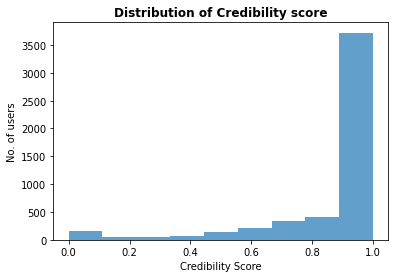

In [56]:
# distribution of scores
plt.hist(list(sum_of_urls_df_prova['credibility_score']), bins=9, alpha=0.7)
plt.xlabel('Credibility Score')
plt.ylabel('No. of users')
plt.title('Distribution of Credibility score', weight='bold')
#plt.savefig('plots/dist', bbox_inches='tight')
plt.show()

In [37]:
print(len(sum_of_urls_df_prova)-len(sum_of_urls_df_prova[sum_of_urls_df_prova["conspiracy_score"].notna()]))
sum_of_urls_df_prova.head(20)

1574


,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score
user_screen_name,,,,,,
infoitinterno,17471,33,17267,171,0,1.0
Paulus00767325,17,0,17,0,0,1.0
RadioRadioWeb,131,0,128,0,3,1.0
RItalia_N,132,0,132,0,0,1.0
sacinaro,19,0,1,1,17,1.0
MarcoMeacci8,19,0,4,3,12,1.0
fainfosalute,133,0,132,1,0,1.0
LucianoTiramani,19,0,15,4,0,1.0
RbBenzi,19,0,15,4,0,1.0


In [38]:
sum_of_urls_df_prova[sum_of_urls_df_prova["conspiracy_score"]>=0.50]

,number_of_urls,HIGH,LOW,UNKW,SOCIAL,conspiracy_score
user_screen_name,,,,,,
infoitinterno,17471,33,17267,171,0,1.0
Paulus00767325,17,0,17,0,0,1.0
RadioRadioWeb,131,0,128,0,3,1.0
RItalia_N,132,0,132,0,0,1.0
sacinaro,19,0,1,1,17,1.0
...,...,...,...,...,...,...
maxjuve,14,2,2,4,6,0.5
marinaamoretti6,14,5,5,4,0,0.5
Universoperso,19,7,7,2,3,0.5


In [ ]:
destination_path = base_path + r"/gianluca.nogara/Desktop/Repo/Vaccines_Discussion_Italy/italian/files/tweets"

In [40]:
tweets_without_useless.to_csv(destination_path + r"/tweets_without_useless_and_score (5.0).csv",
                              line_terminator="\n", index=False, encoding="utf-8")

# Low / tweets

In [41]:
sum_of_urls_df

,number_of_urls,HIGH,LOW,UNKW,SOCIAL
user_screen_name,,,,,
infoitinterno,17471,33,17267,171,0
infoitsalute,16086,33,15859,194,0
infoiteconomia,6120,24,6031,65,0
zazoomblog,6033,0,6024,9,0
Notiziedi_it,3529,3529,0,0,0
...,...,...,...,...,...
SDoria9,1,0,0,1,0
SDellabella,1,1,0,0,0
SCostarelli,1,0,0,1,0
